# **Check GPU**

In [4]:
!nvidia-smi

Mon Sep  2 19:44:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Requirements**

In [5]:
!pip install roboflow
!pip install ultralytics

  Using cached ultralytics-8.2.86-py3-none-any.whl.metadata (41 kB)
  Using cached ultralytics_thop-2.0.6-py3-none-any.whl.metadata (9.1 kB)
Using cached ultralytics-8.2.86-py3-none-any.whl (872 kB)
Using cached ultralytics_thop-2.0.6-py3-none-any.whl (26 kB)


# **Roboflow Dataset**

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4LkXLK8ZSbLkfVFlFbMf")
project = rf.workspace("project-p5nyc").project("car-parts-o7dlr")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.86, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Car-parts-1 in yolov8:: 100%|██████████| 6594/6594 [00:00<00:00, 7687.35it/s]


# **LIBRARIES**

In [7]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

# **DEPENDENCIES**

In [8]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [9]:
dataset_dir = f'{HOME}/Car-parts-1/'
models_dir = f'{HOME}/models'
os.makedirs(models_dir, exist_ok=True)

# **Visualize Samples**

In [10]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [11]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [12]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

In [13]:
# Visualize a few training images.
plot(
    image_paths=f'{dataset_dir}/train/images/',
    label_paths=f'{dataset_dir}/train/labels/',
    num_samples=4,
)

ValueError: too many values to unpack (expected 4)

<Figure size 1500x1200 with 0 Axes>

# **YOLOv8**

In [14]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [15]:
modelS = YOLO(f"{models_dir}/yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 172MB/s]


WARNING ⚠️ 'source' is missing. Using 'source=/opt/conda/lib/python3.10/site-packages/ultralytics/assets'.


[ WARN:0@172.580] global loadsave.cpp:241 findDecoder imread_('/kaggle/working/test_image.jpg'): can't open/read file: check file path/integrity



image 1/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 43.5ms
image 2/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 43.2ms
Speed: 4.9ms preprocess, 43.4ms inference, 117.3ms postprocess per image at shape (1, 3, 384, 640)


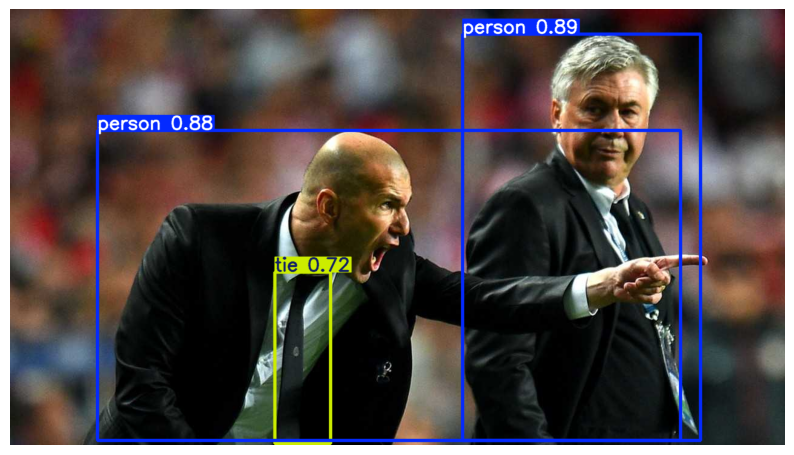

In [16]:
TEST_IMAGE_PATH = f'{HOME}/test_image.jpg'
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)
# TEST_IMAGE = cv2.resize(TEST_IMAGE, (640, 640))
CHECK_TEST_RESULT = modelS.predict(source=TEST_IMAGE, conf=0.5, save=False, imgsz=640)

plt.figure(figsize=(10, 10))
for result in CHECK_TEST_RESULT:
    plotted_image = result.plot()
    plotted_image_rgb = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(plotted_image_rgb)
    plt.axis('off')
plt.show()

# **Create YAML file**

In [17]:
yamlPath = f'{dataset_dir}/data.yaml'

In [22]:
yamlContent = f"""
path: '{dataset_dir}'
test: 'test/images'
train: 'train/images'
val: 'valid/images'

# class names
nc: 20
names:
  0: car boot
  1: car hood
  2: driver-s door - -F-R-
  3: fender - -F-L-
  4: fender - -F-R-
  5: fender - -R-L-
  6: fender - -R-R-
  7: front bumper
  8: headlight - -L-
  9: headlight - -R-
  10: passenger-s door - -F-L-
  11: passenger-s door - -R-L-
  12: passenger-s door - -R-R-
  13: rear bumper
  14: rear light - -L-
  15: rear light - -R-
  16: side bumper - -L-
  17: side bumper - -R-
  18: side mirror - -L-
  19: side mirror - -R-
"""

with open(f'{yamlPath}', 'w') as yaml:
    yaml.write(yamlContent)

# **Parameters**

In [25]:
EPOCHS = 25
IMAGE_SIZE = 640
BATCH = 32
NAME = 'yolov8s_beesv2'

# **Train**

In [26]:
# Train Model
modelS.train(
    data=yamlPath,            # Path to the dataset configuration file
    epochs=EPOCHS,            # Number of epochs to train for
    imgsz=IMAGE_SIZE,         # Image size
    batch=BATCH,              # Batch size
    name=NAME                 # Name of the training run
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/models/yolov8s.pt, data=/kaggle/working/Car-parts-1//data.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_beesv22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
2024-09-02 19:53:49,287	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-02 19:53:49,808	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
train: Scanning /kaggle/working/Car-parts-1/train/labels... 2796 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2796/2796 [00:02<00:00, 1140.96it/s]


train: New cache created: /kaggle/working/Car-parts-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/Car-parts-1/valid/labels... 328 images, 0 backgrounds, 0 corrupt: 100%|██████████| 328/328 [00:00<00:00, 1445.45it/s]

val: New cache created: /kaggle/working/Car-parts-1/valid/labels.cache


Plotting labels to runs/detect/yolov8s_beesv22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_beesv22
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         8G      2.679      4.275       2.36        167        640: 100%|██████████| 88/88 [00:49<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        328       3037      0.797     0.0759      0.112     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      7.93G      1.929      2.503       1.74        166        640: 100%|██████████| 88/88 [00:46<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        328       3037      0.397      0.467      0.359      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      7.94G      1.686      1.896      1.566        166        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

                   all        328       3037      0.411      0.574      0.428      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      7.95G      1.587      1.635      1.477        182        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

                   all        328       3037      0.465      0.663      0.502      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      7.49G      1.515      1.506      1.427        158        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all        328       3037      0.464      0.705      0.496      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      8.03G      1.486      1.428      1.404        177        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        328       3037      0.477      0.724      0.523      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      7.86G      1.454      1.361      1.375        173        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        328       3037      0.507      0.724      0.552      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      7.36G      1.436       1.32      1.361        185        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        328       3037      0.514       0.76      0.596      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      8.26G      1.426      1.296      1.356        192        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        328       3037       0.52      0.762      0.591      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      7.49G      1.403       1.26      1.339        156        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        328       3037      0.516      0.775      0.589      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      8.98G       1.39      1.234      1.337        110        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        328       3037      0.502      0.793      0.599      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      8.32G      1.374      1.206      1.323        226        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        328       3037      0.532      0.789      0.587      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      8.23G      1.372      1.189       1.32        228        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]

                   all        328       3037      0.524      0.791      0.607       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      7.53G      1.351       1.17      1.308        169        640: 100%|██████████| 88/88 [00:45<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        328       3037      0.536      0.809      0.619      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      7.89G      1.338       1.15      1.298        209        640: 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all        328       3037      0.535      0.808      0.609      0.352


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      7.87G       1.31      1.083      1.335        109        640: 100%|██████████| 88/88 [00:47<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        328       3037      0.542      0.778      0.648      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      8.02G      1.295      1.057      1.317        126        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        328       3037       0.53      0.812      0.611      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      7.44G      1.284      1.038      1.314        119        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        328       3037      0.538      0.811      0.625      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       7.9G      1.272      1.026      1.311        122        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        328       3037      0.527      0.826      0.622      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      7.84G      1.265      1.011      1.301        117        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        328       3037      0.541      0.816      0.632      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      7.97G      1.257      1.001      1.295        126        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        328       3037      0.542      0.818      0.642      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      7.88G      1.248     0.9883      1.289         97        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        328       3037      0.532      0.824      0.641      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      7.88G      1.239     0.9833      1.285        119        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        328       3037      0.539      0.829      0.646      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      7.89G      1.235     0.9708      1.281        117        640: 100%|██████████| 88/88 [00:44<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        328       3037      0.542      0.822      0.646       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      7.96G      1.231     0.9662      1.277        112        640: 100%|██████████| 88/88 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        328       3037      0.547       0.82      0.653      0.385



25 epochs completed in 0.344 hours.
Optimizer stripped from runs/detect/yolov8s_beesv22/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_beesv22/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_beesv22/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


                   all        328       3037      0.547       0.82      0.653      0.385
              car boot         63         64      0.786      0.859      0.878      0.637
              car hood        267        274      0.946      0.985      0.974      0.779
 driver-s door - -F-R-        108        110      0.498      0.973      0.724      0.438
        fender - -F-L-        118        119      0.493      0.924      0.646      0.358
        fender - -F-R-        104        105      0.421      0.876      0.559      0.276
        fender - -R-L-        102        102      0.443       0.48      0.462      0.159
        fender - -R-R-         81         86      0.372        0.2      0.282     0.0916
          front bumper        277        283      0.943      0.968      0.958       0.71
       headlight - -L-        230        233      0.523       0.91       0.72      0.465
       headlight - -R-        236        241      0.507      0.925      0.658      0.395
passenger-s door - -F

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7928a54340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

# **Validate**

In [27]:
evaluateCARS_Sval = modelS.val(
    data = yamlPath,
    split = 'val',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/working/Car-parts-1/valid/labels.cache... 328 images, 0 backgrounds, 0 corrupt: 100%|██████████| 328/328 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


                   all        328       3037      0.547       0.82      0.653      0.385
              car boot         63         64      0.787      0.859      0.878      0.636
              car hood        267        274      0.946      0.985      0.974      0.779
 driver-s door - -F-R-        108        110      0.501      0.973      0.724      0.436
        fender - -F-L-        118        119      0.494      0.925      0.646      0.357
        fender - -F-R-        104        105      0.421      0.876      0.559      0.276
        fender - -R-L-        102        102      0.441       0.48      0.457      0.158
        fender - -R-R-         81         86      0.372        0.2      0.281     0.0919
          front bumper        277        283      0.943      0.968      0.958      0.709
       headlight - -L-        230        233      0.525       0.91      0.721      0.466
       headlight - -R-        236        241      0.507      0.925      0.658      0.395
passenger-s door - -F

# **Evaluate**

In [28]:
evaluateCARS_Stest = modelS.val(
    data = yamlPath,
    split = 'test',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/Car-parts-1/test/labels... 167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 167/167 [00:00<00:00, 1302.63it/s]

val: New cache created: /kaggle/working/Car-parts-1/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


                   all        167       1648      0.568      0.788      0.665      0.372
              car boot         16         17      0.711          1      0.809      0.576
              car hood        151        160       0.99      0.963      0.979      0.737
 driver-s door - -F-R-         60         62      0.516      0.935      0.763      0.418
        fender - -F-L-         69         70      0.535      0.888      0.662       0.35
        fender - -F-R-         61         64      0.444      0.766      0.559      0.294
        fender - -R-L-         58         62      0.456      0.355      0.483      0.166
        fender - -R-R-         48         50      0.572       0.18      0.323      0.135
          front bumper        152        159       0.91       0.95      0.946      0.706
       headlight - -L-        122        129      0.501      0.811       0.64      0.395
       headlight - -R-        123        128      0.521       0.93      0.714      0.428
passenger-s door - -F

# **Download**

In [29]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

from IPython.display import FileLink
FileLink(r'runs.zip')

/kaggle/working/runs.zip

# **PLOTS**

In [30]:
from IPython.display import display, Image
from IPython import display
display.clear_output()

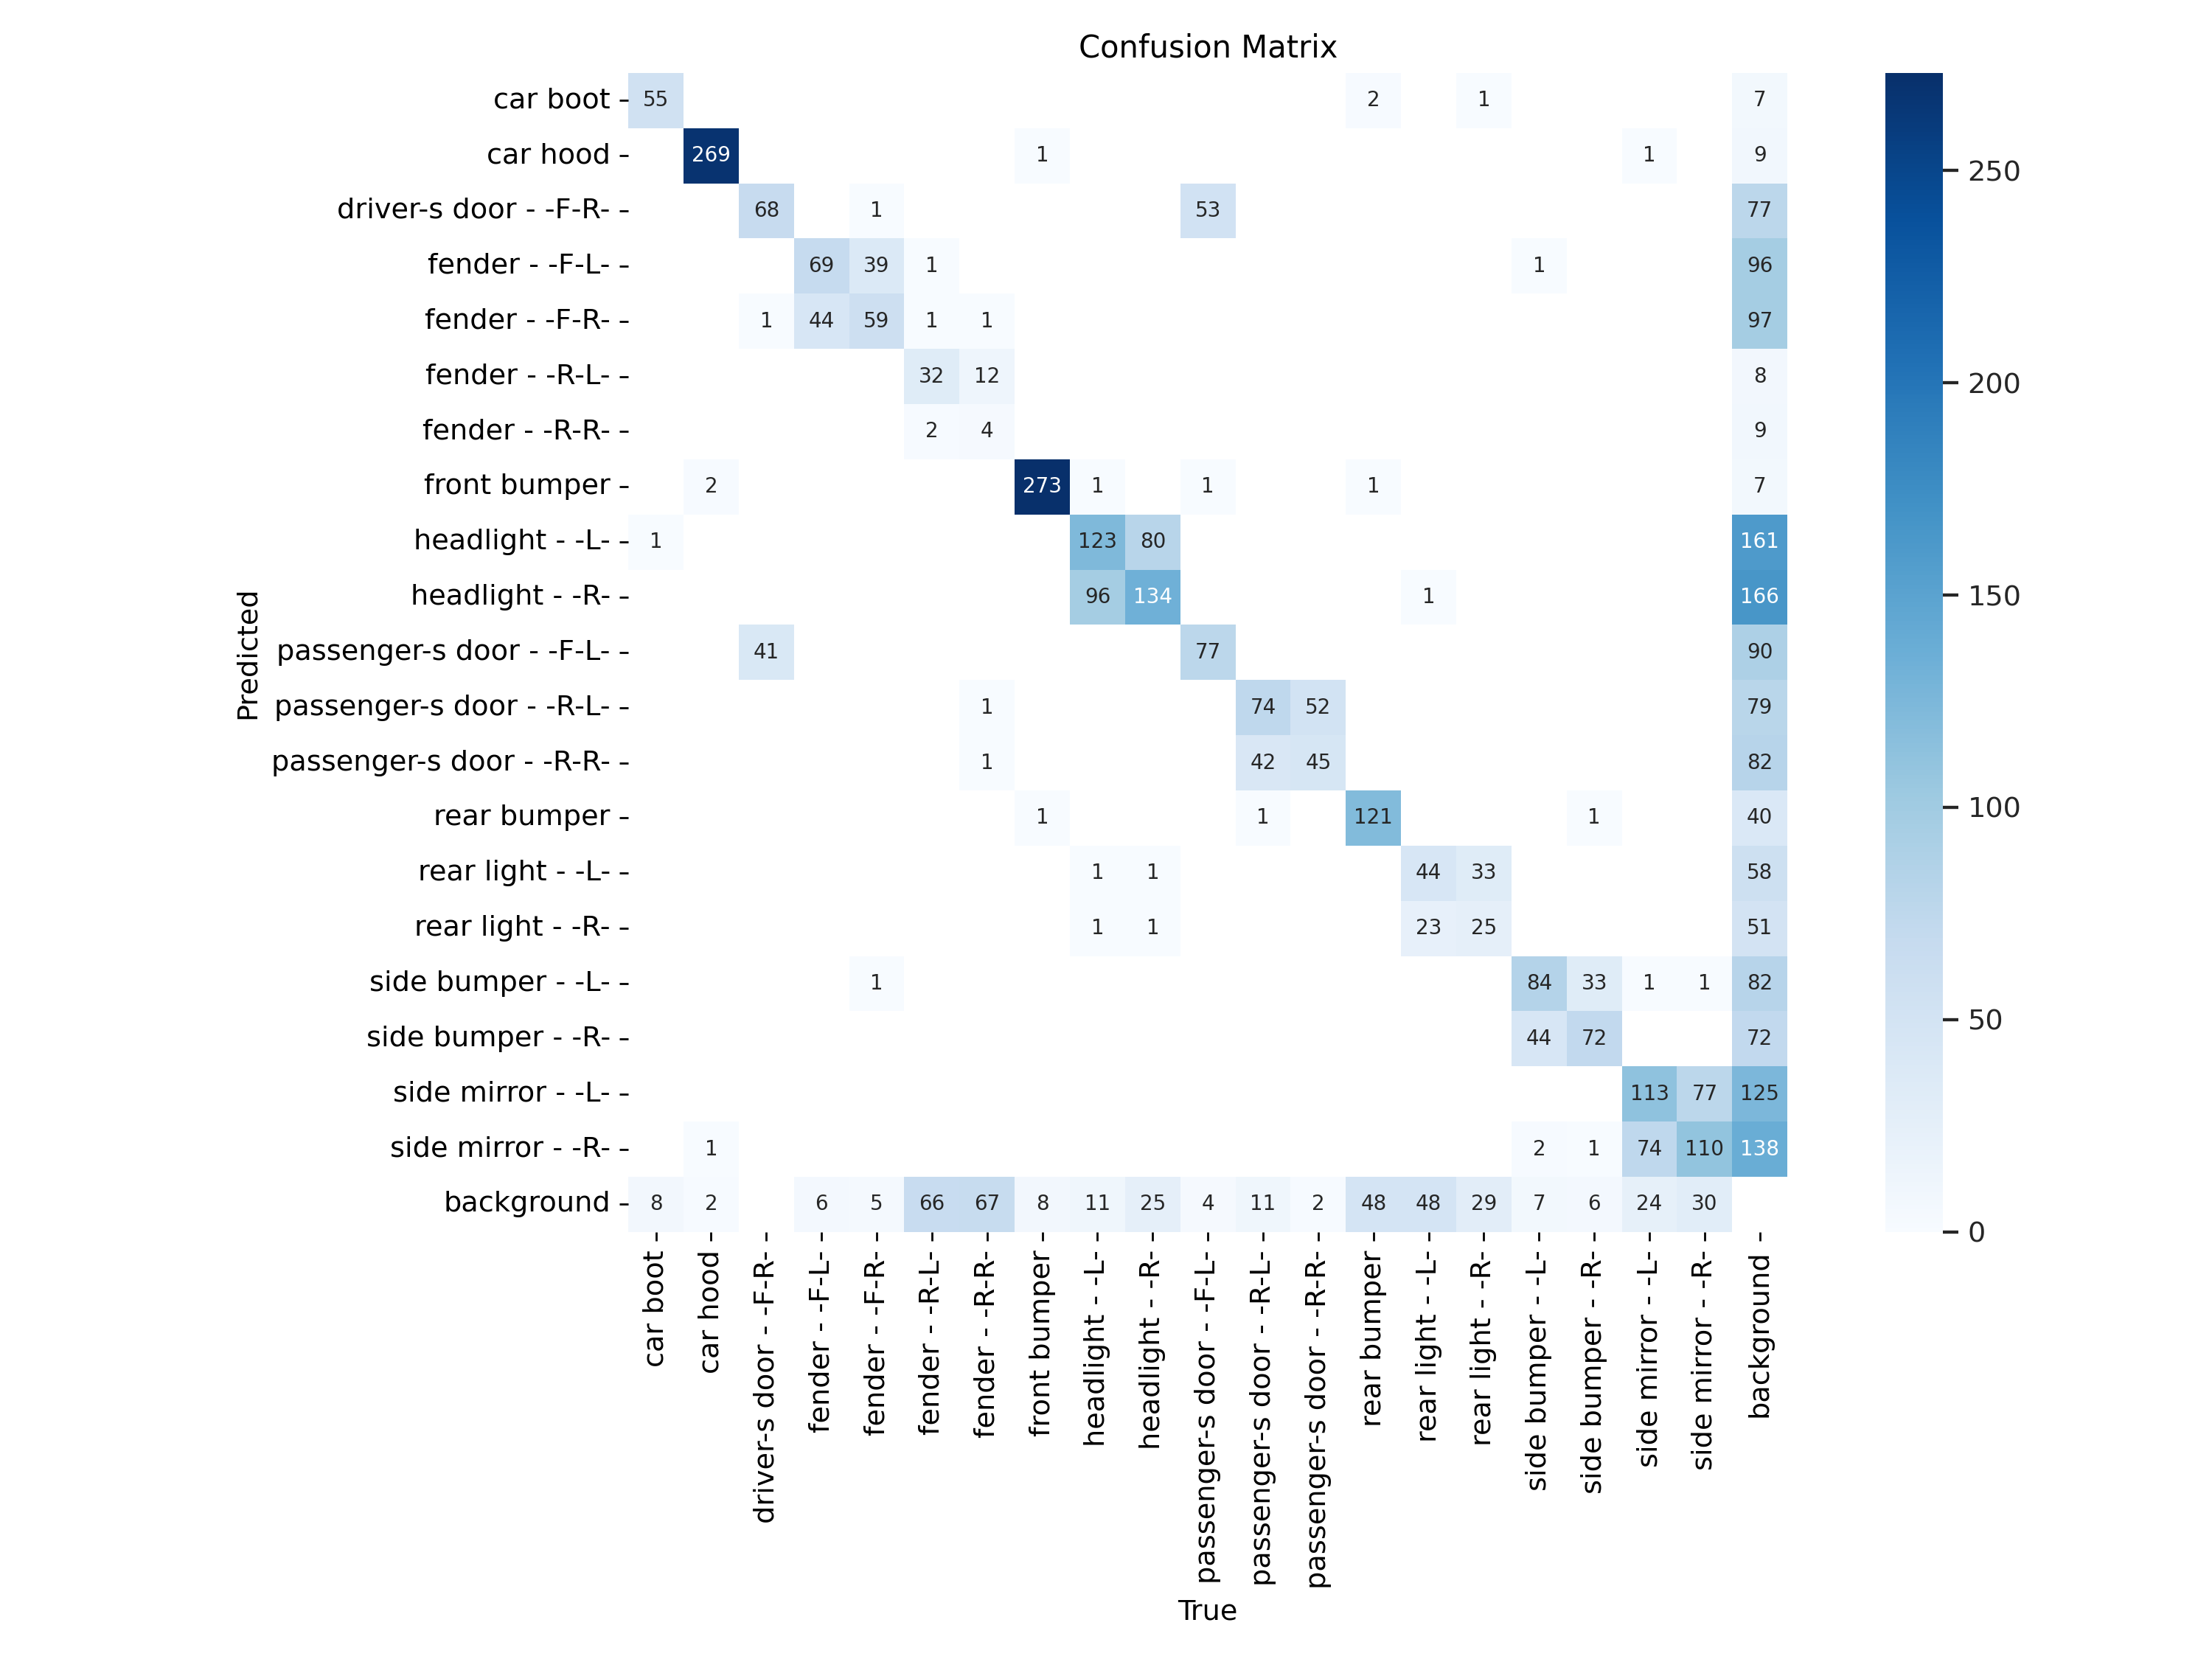

In [35]:
Image(filename=f'{HOME}/runs/detect/{NAME}2/confusion_matrix.png', width=600)

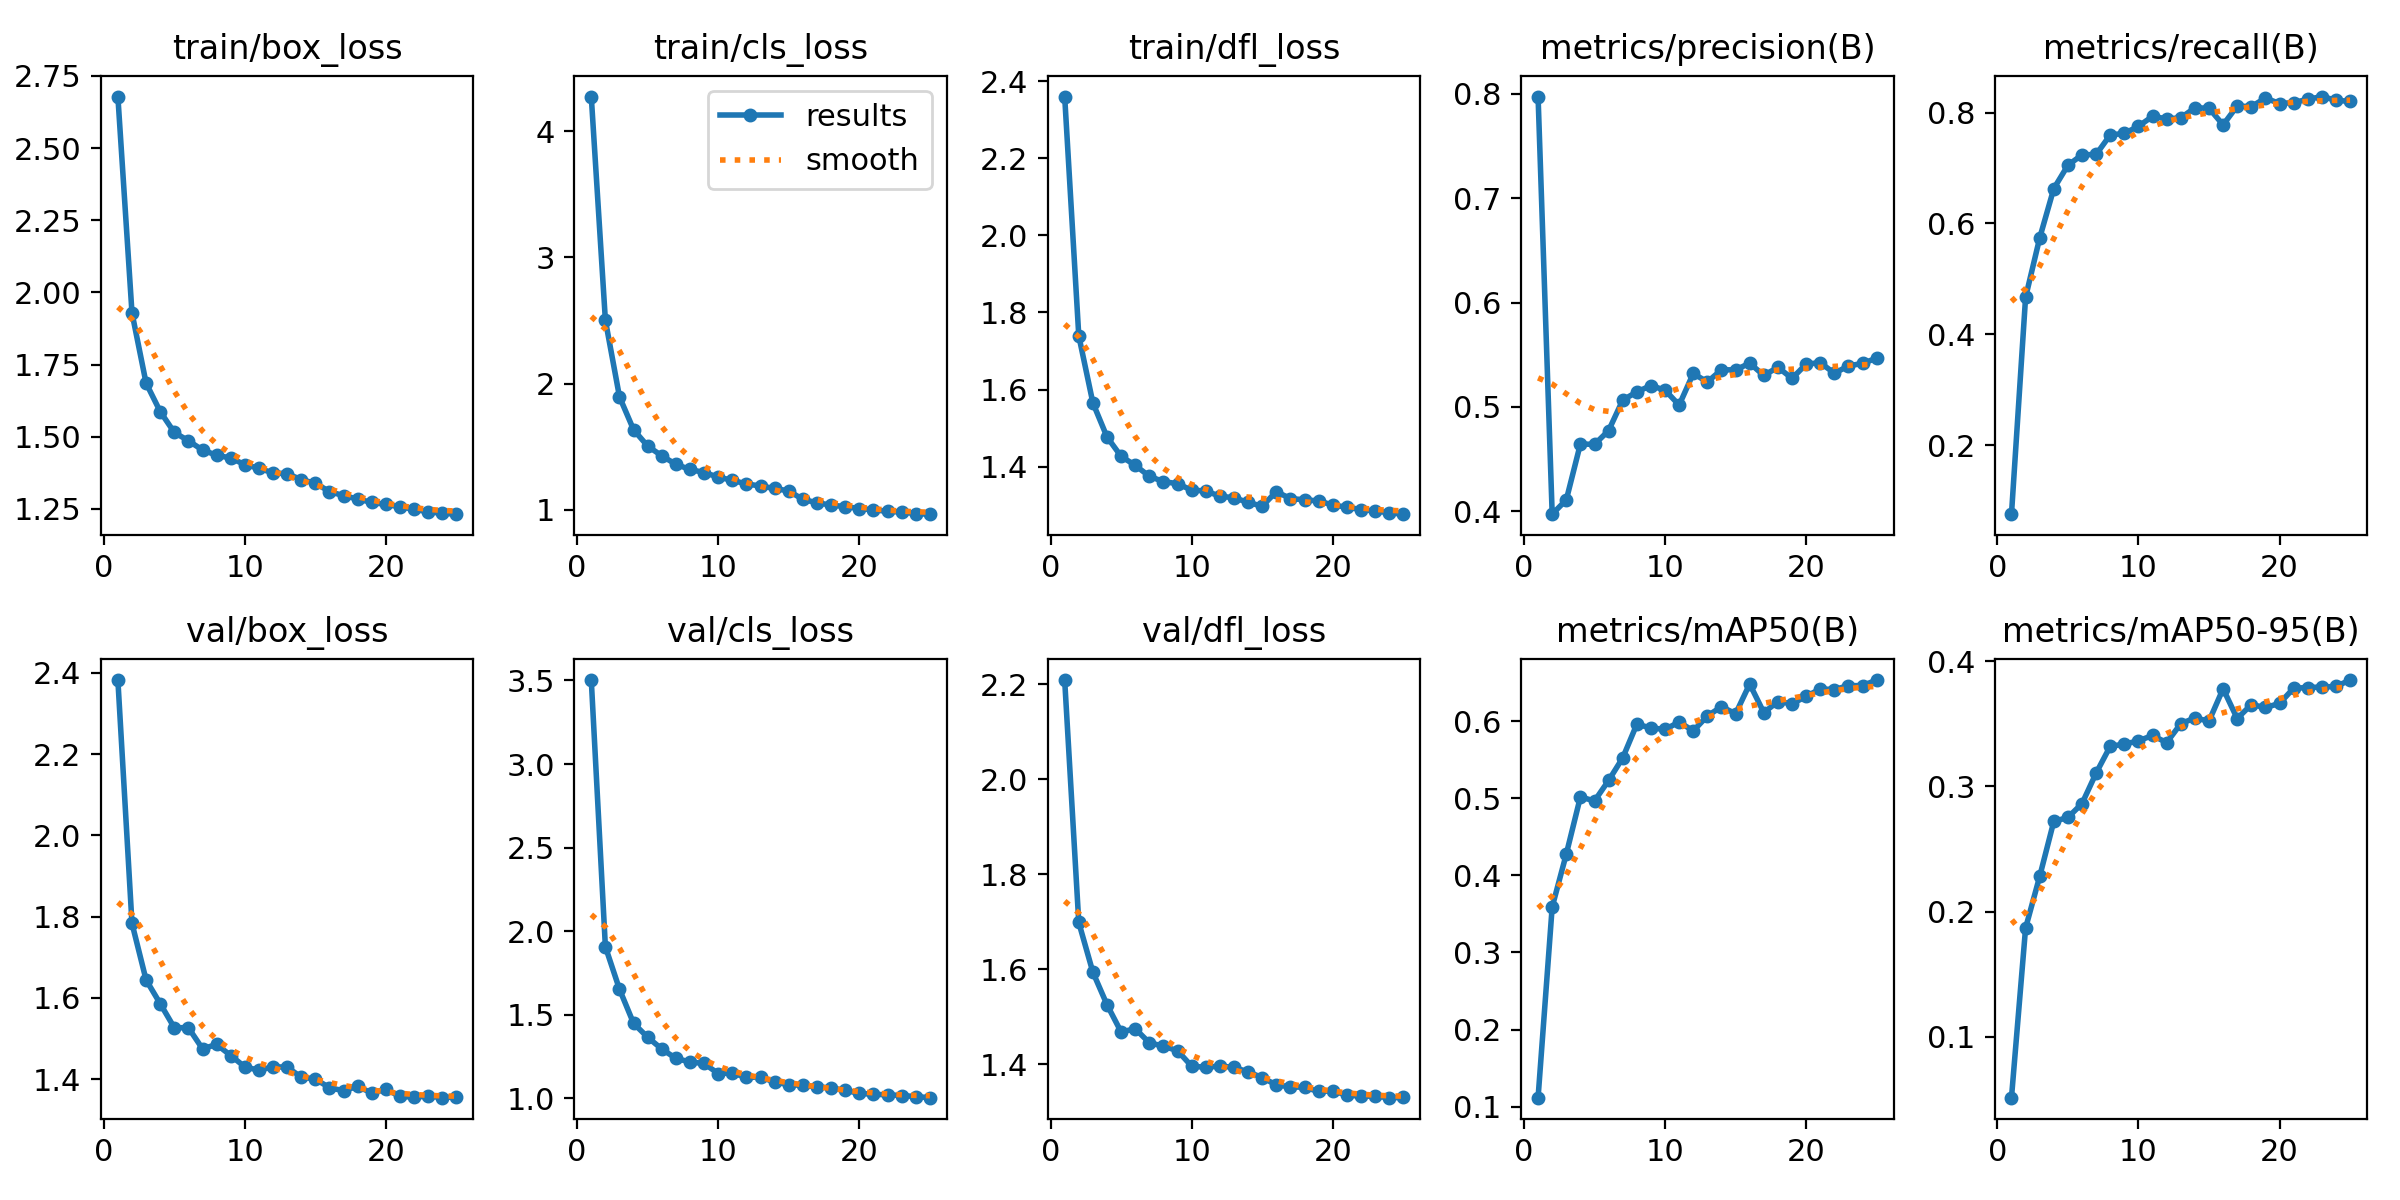

In [36]:
Image(filename=f'{HOME}/runs/detect/{NAME}2/results.png', width=600)

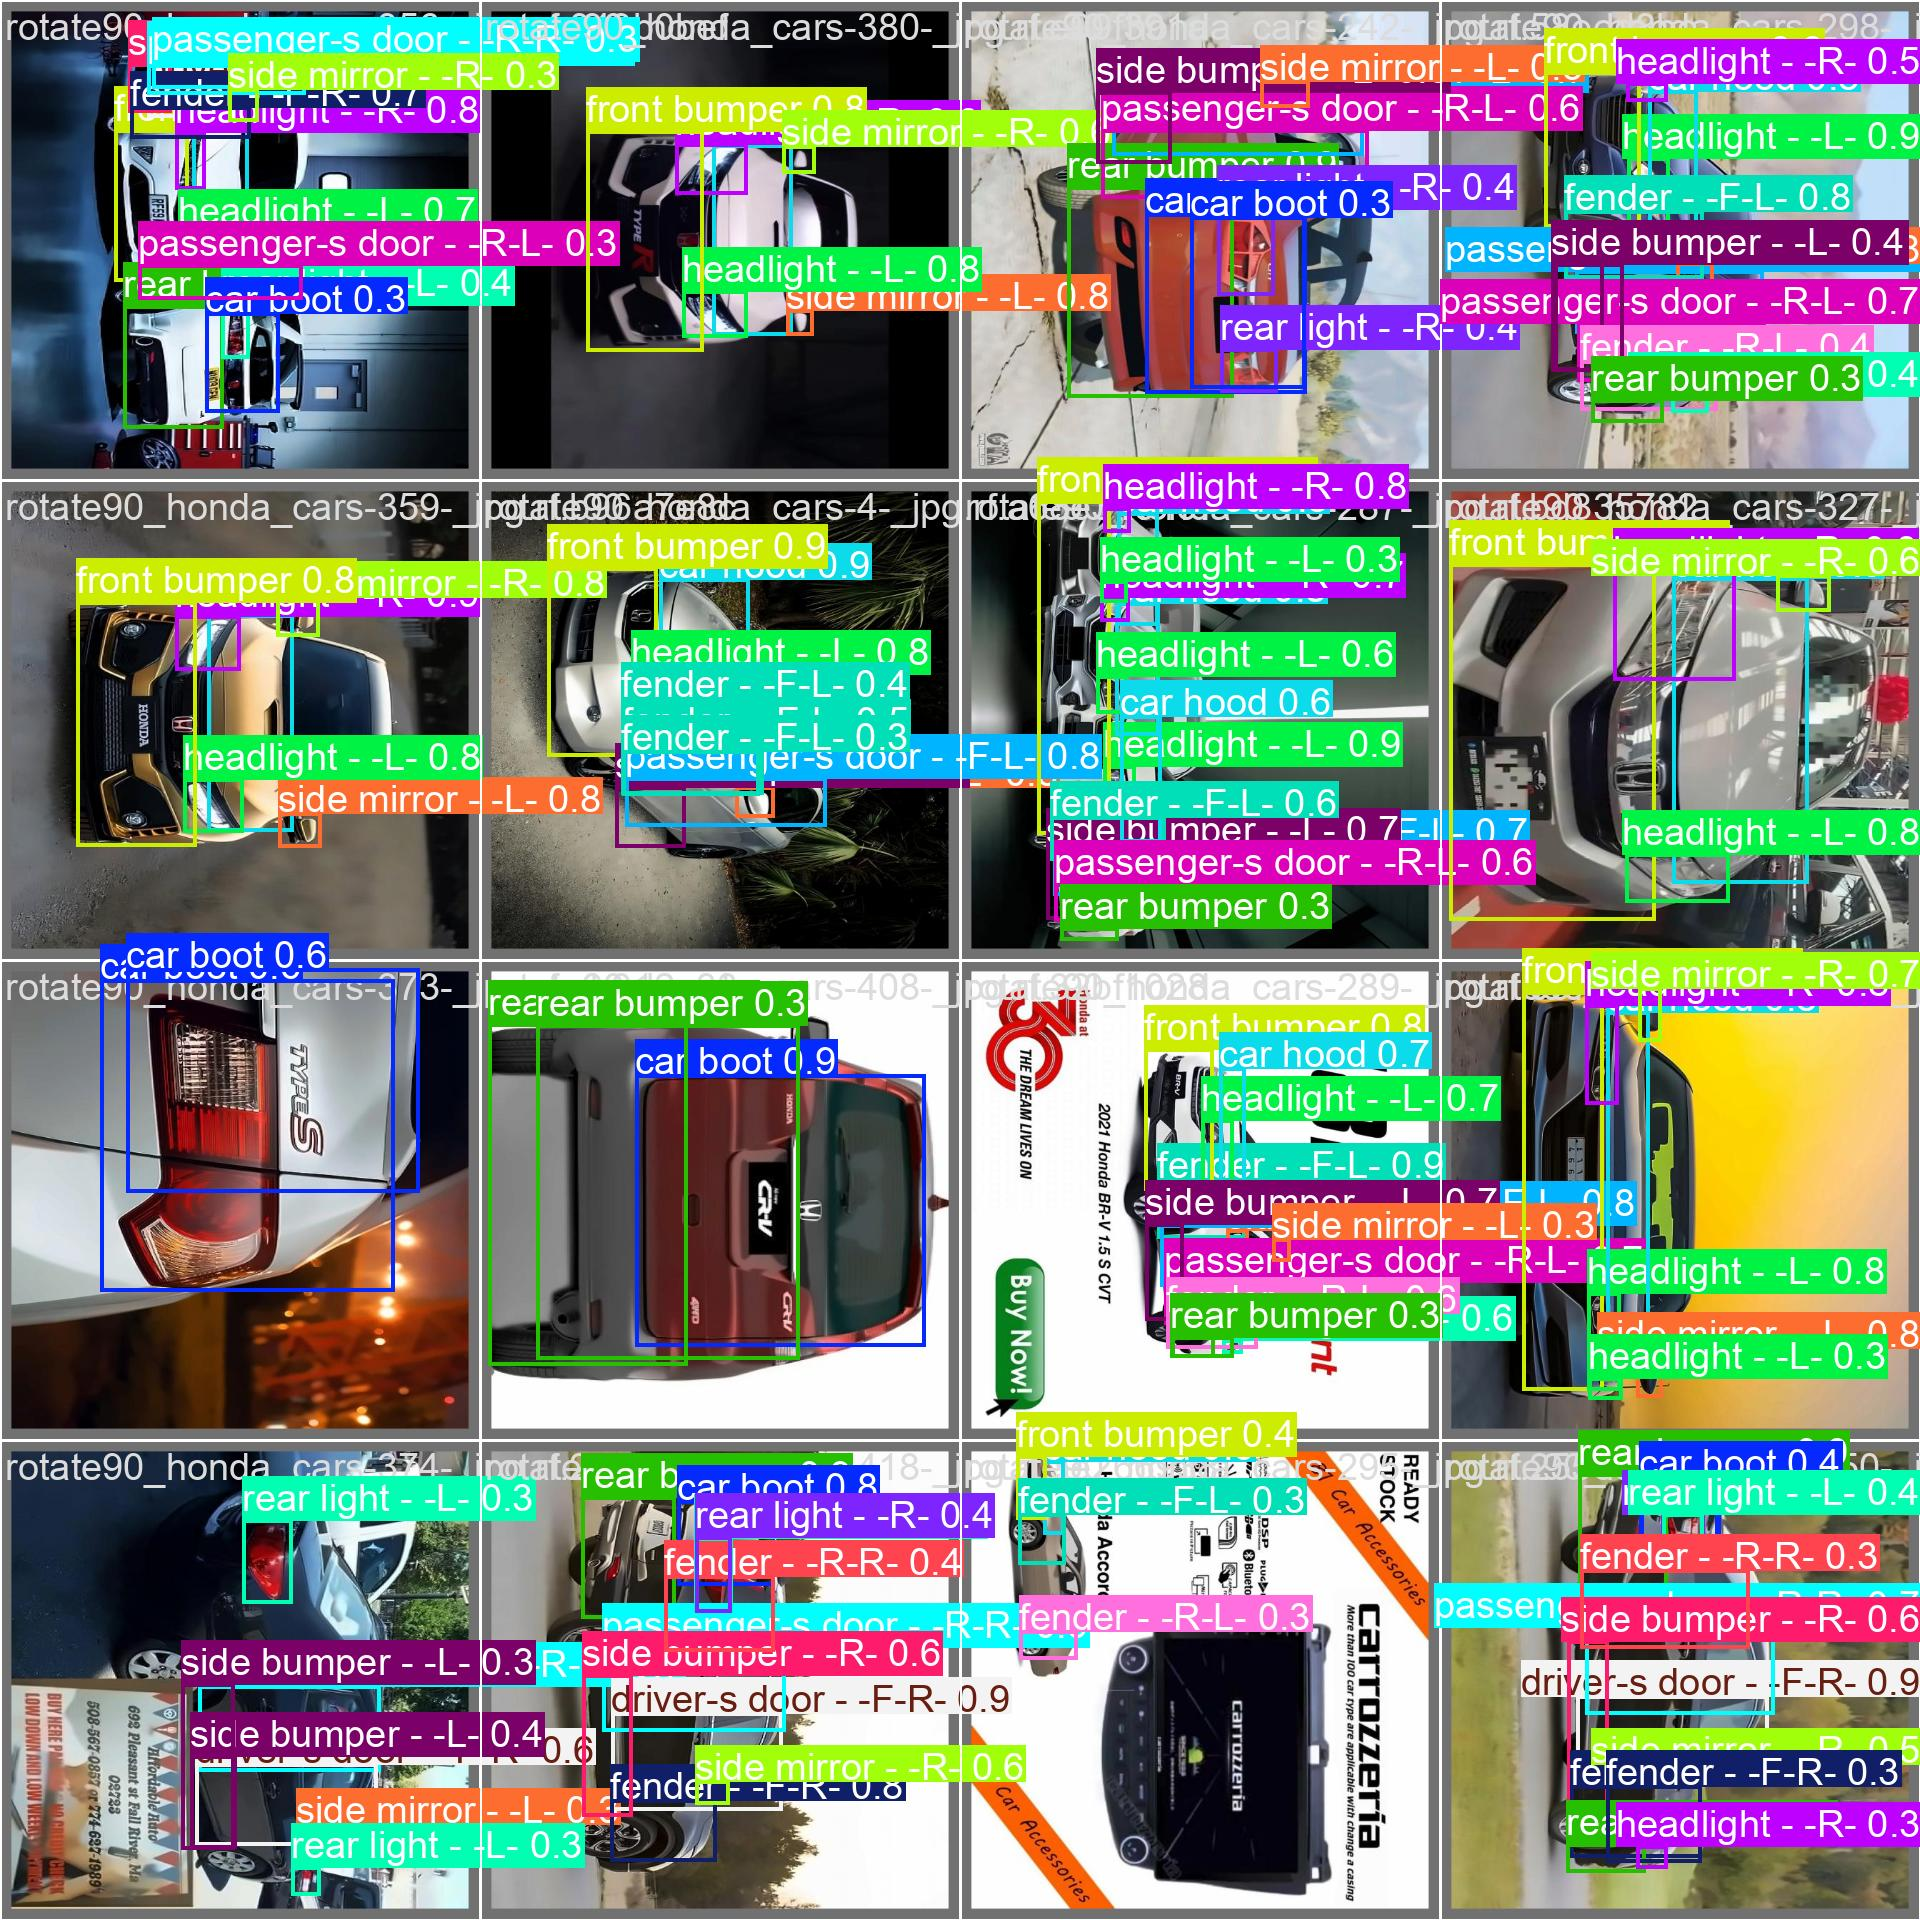

In [37]:
Image(filename=f'{HOME}/runs/detect/{NAME}2/val_batch0_pred.jpg', width=600)

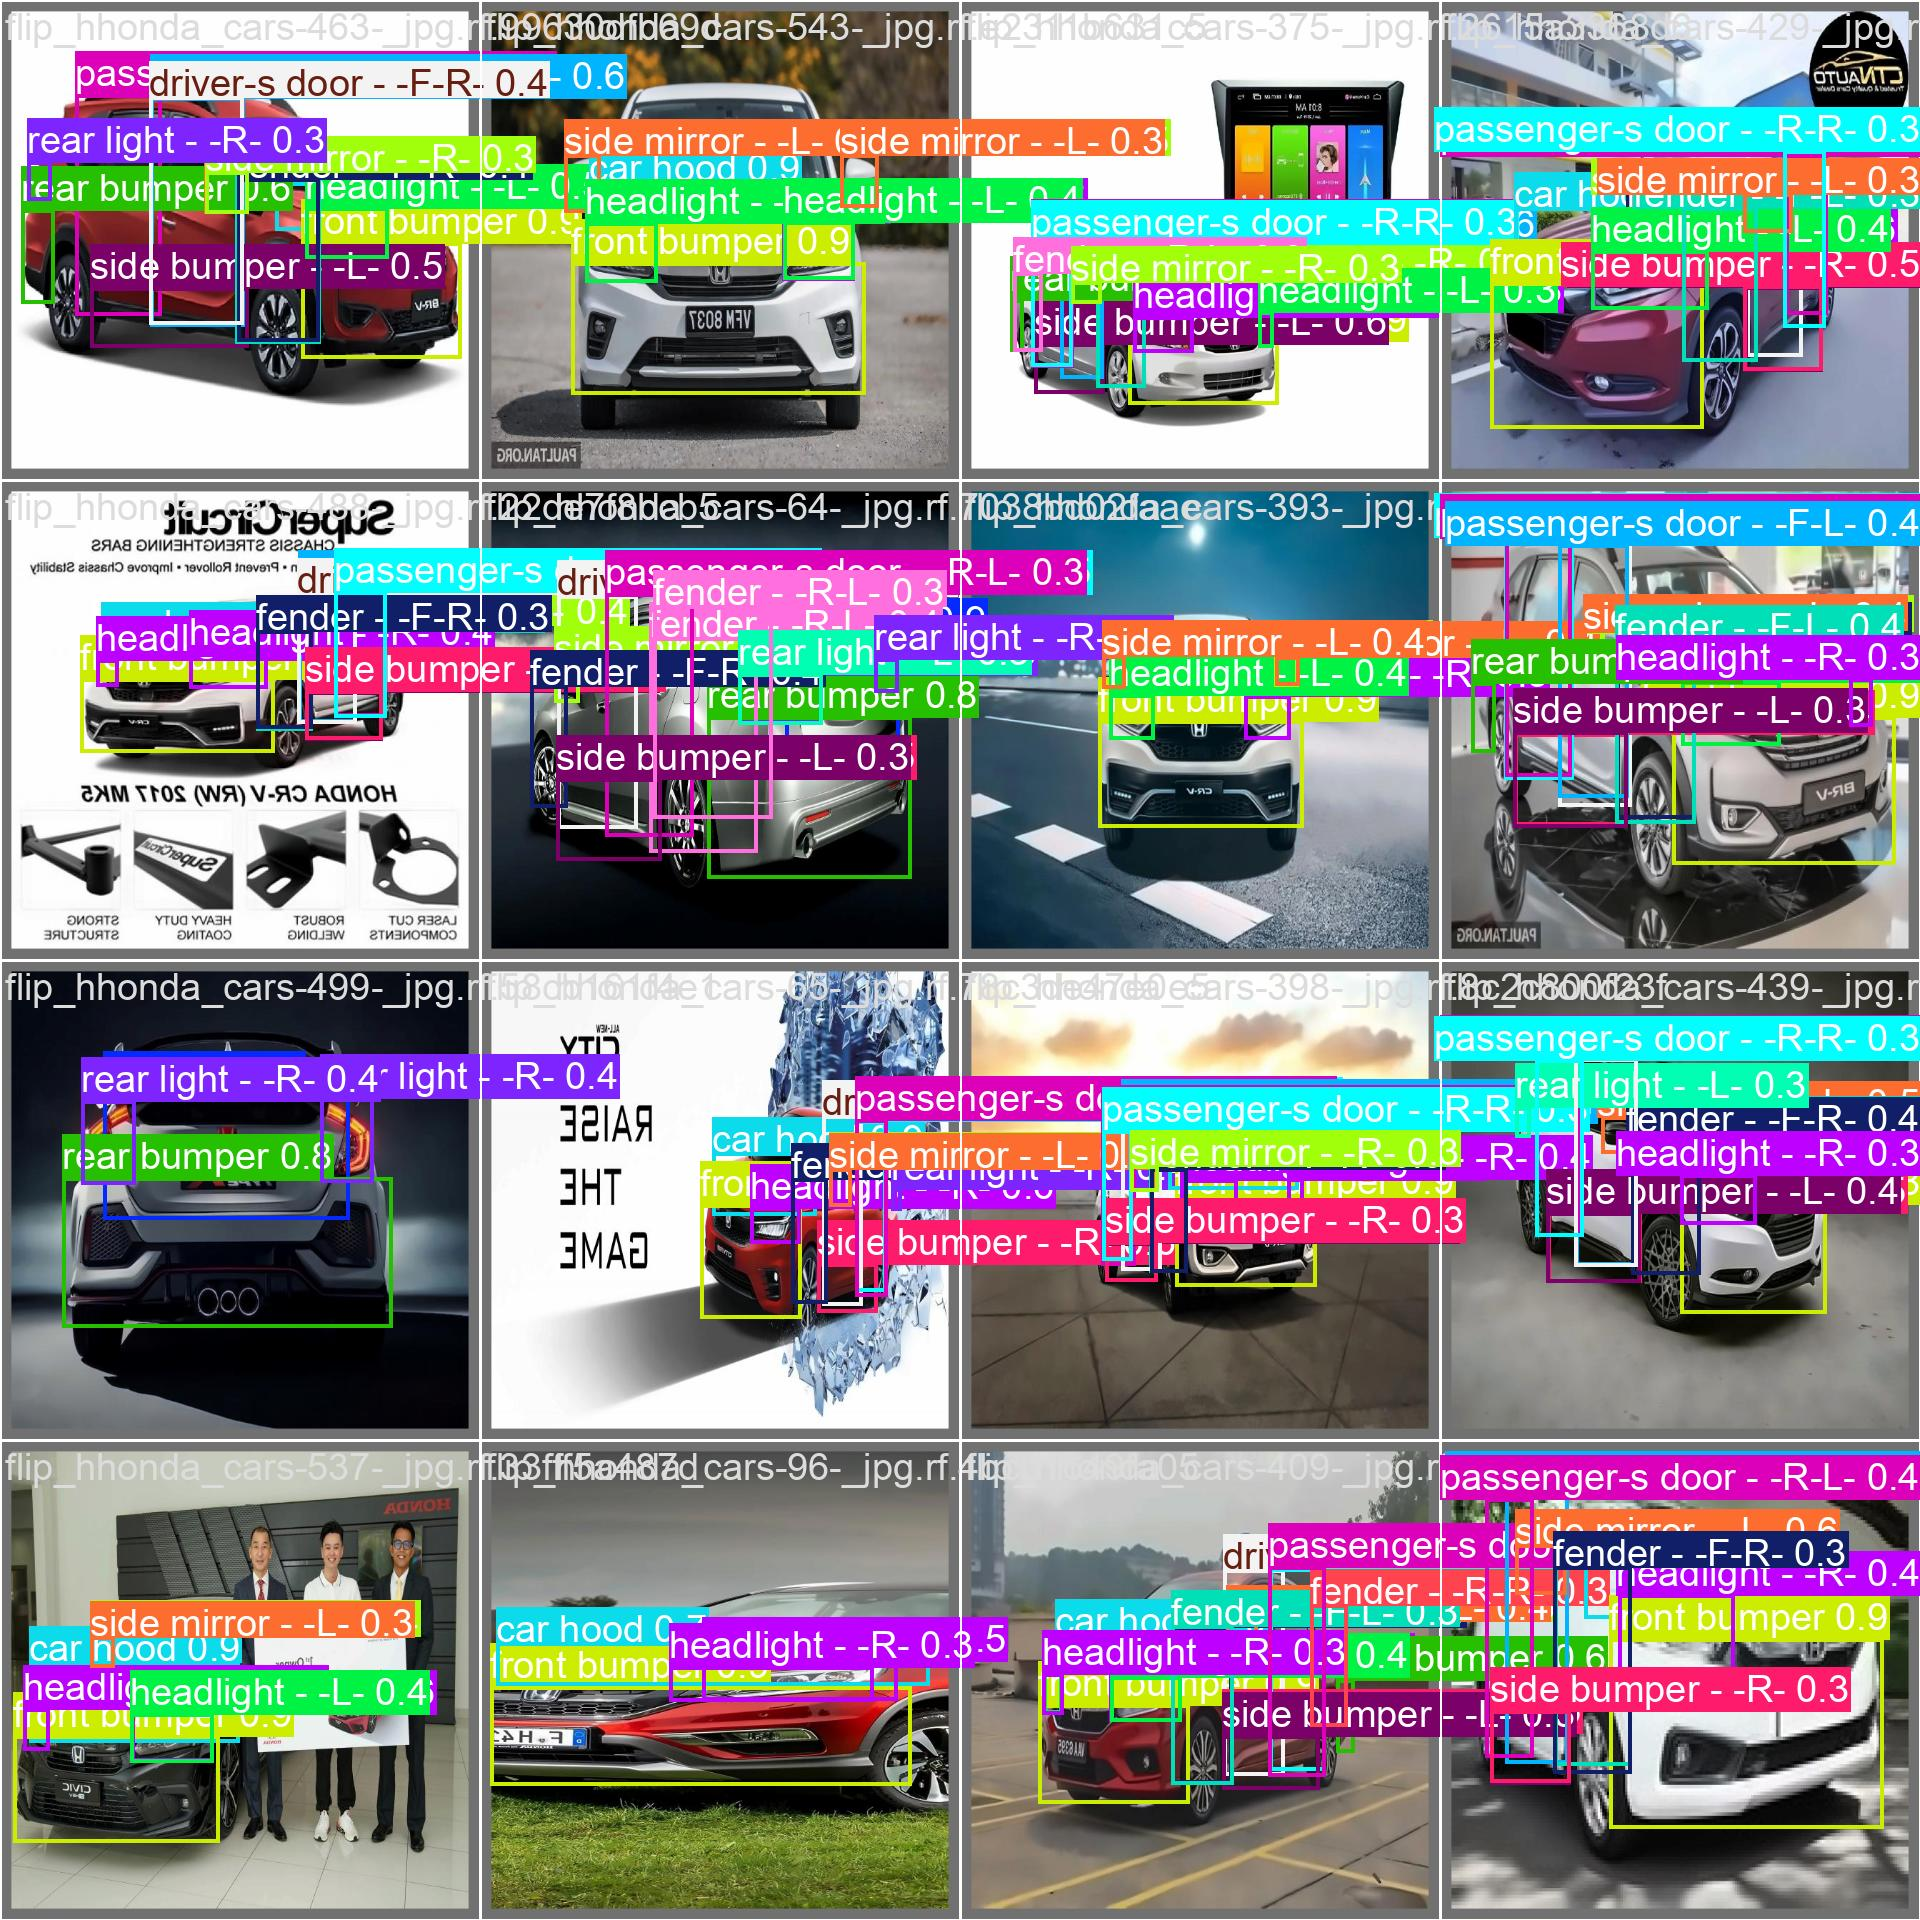

In [38]:
Image(filename=f'{HOME}/runs/detect/{NAME}2/val_batch1_pred.jpg', width=600)